In [49]:
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os

import matplotlib.pyplot as plt

from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

# try:
#     from tqdm import tqdm # long waits are not fun
# except:
#     print('TQDM does make much nicer wait bars...')
#     tqdm = lambda x: x

## file_list

In [50]:
# Getting list of image files
path = "D:/Lung cancer/"
subset_path = path + "SUBSETS/subset0/"
output_path = path + 'output/'
working_path = path + 'working/'

file_list = glob(subset_path + "*.mhd")

In [51]:
#------------ Helper function -------------
#to get rows in data frame associated with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)

In [52]:
# The locations of the nodules
df_annotations = pd.read_csv(path + "csv/annotations.csv")
df_annotations["file"] = df_annotations["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_annotations = df_annotations.dropna()

## make_mask

In [14]:
#------------ Helper function -------------
def make_mask(center,diam,z,width,height,spacing,origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [15]:
#------------ Helper function -------------
def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

## save_mask

In [16]:
'''
Should we collect more slices from each scan?
Since the nodule locations are defined in terms of spheres, and the nodules are irregularly shaped, 
slices near the edges of the spheres may contain no nodule tissue. Using such slices would contaminate 
the training set with false positives. For this segmentation project, there is probably an optimal number 
of slices through a nodule that one should incorporate. For simplicity, we stick to 3 and only pull the 
slices centered on the largest nodule.
'''

def save_mask(file_list, csv):
    for file_idx, img_file in enumerate(file_list):
        mini_df = df_annotations[df_annotations["file"]==img_file] #get all nodules associate with file
        if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
            # load the data once
            itk_img = sitk.ReadImage(img_file) 
            img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
            num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            # go through all nodes (why just the biggest?)
            for node_idx, cur_row in mini_df.iterrows():       
                node_x = cur_row["coordX"]
                node_y = cur_row["coordY"]
                node_z = cur_row["coordZ"]
                diam = cur_row["diameter_mm"]
                # just keep 3 slices
                imgs = np.ndarray([3,height,width],dtype=np.float32)
                masks = np.ndarray([3,height,width],dtype=np.uint8)
                center = np.array([node_x, node_y, node_z])   # nodule center
                v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
                for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                                 int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                    mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                     width, height, spacing, origin)
                    masks[i] = mask
                    imgs[i] = img_array[i_z]

                np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (file_idx, node_idx)),imgs)
                np.save(os.path.join(output_path,"masks_%04d_%04d.npy" % (file_idx, node_idx)),masks)

In [17]:
# save_mask(file_list, df_annotations)

## plot some samples

image 0


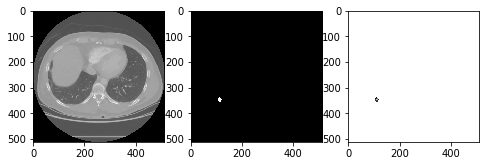

image 1


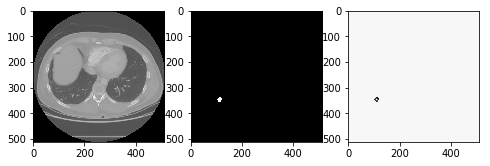

image 2


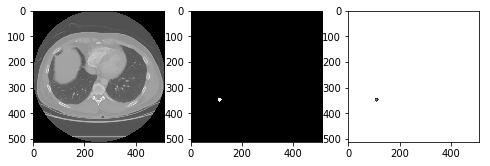

In [18]:
imgs = np.load(output_path+'images_0001_0023.npy')
masks = np.load(output_path+'masks_0001_0023.npy')
for i in range(len(imgs)):
    print("image %d" % i)
    fig,ax = plt.subplots(1,3,figsize=[8,8])
    ax[0].imshow(imgs[i],cmap='gray')
    ax[1].imshow(masks[i],cmap='gray')
    ax[2].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show();

## ROI

In [53]:
output_list = glob(output_path + 'images_*.npy')

In [20]:
# Isolation of the Lung ROI to Narrow Nodule Search

def ROI_lungmask(output_list):    
    for img_file in tqdm(output_list):
        # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
        imgs_to_process = np.load(img_file).astype(np.float64) 
        print("on image", img_file)
        for i in range(len(imgs_to_process)):
            img = imgs_to_process[i]
    # THRESHOLDING
            #Standardize the pixel values
            mean = np.mean(img)
            std = np.std(img)
            img = img-mean
            img = img/std
            # Find the average pixel value near the lungs to renormalize washed out images
            middle = img[100:400,100:400] 
            mean = np.mean(middle)  
            max = np.max(img)
            min = np.min(img)
            # To improve threshold finding, I'm moving the underflow and overflow on the pixel spectrum
            img[img==max]=mean
            img[img==min]=mean
            #
            # Use Kmeans to separate foreground(radio-opaque tissue)and background(radio transparent tissue ie lungs)
            # Do this only on the center of the image to avoid the non-tissue parts of the image as much as possible
            #
            kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
            centers = sorted(kmeans.cluster_centers_.flatten())
            threshold = np.mean(centers)
            thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
            #
            # I found an initial erosion helful for removing graininess from some of the regions
            # and then large dialation is used to make the lung region 
            # engulf the vessels and incursions into the lung cavity by radio opaque tissue
    # EROSION & DILATION
            eroded = morphology.erosion(thresh_img,np.ones([4,4]))
            dilation = morphology.dilation(eroded,np.ones([10,10]))
            #
            #  Label each region and obtain the region properties
            #  The background region is removed by removing regions with a bbox that is to large in either dimnsion
            #  Also, the lungs are generally far away from the top and bottom of the image, so any regions that 
            #are too close to the top and bottom are removed
            #  This does not produce a perfect segmentation of the lungs from the image, but it is 
            #surprisingly good considering its simplicity. 
            #
    # CUTTING non-ROI REGIONS
            labels = measure.label(dilation)
            label_vals = np.unique(labels)
            regions = measure.regionprops(labels)
            good_labels = []
            for prop in regions:
                B = prop.bbox
                if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
                    good_labels.append(prop.label)
            mask = np.ndarray([512,512],dtype=np.int8)
            mask[:] = 0
            #
            #  The mask here is the mask for the lungs--not the nodes
            #  After just the lungs are left, we do another large dilation in order to fill in and out the lung mask 
            #
            for N in good_labels:
                mask = mask + np.where(labels==N,1,0)
            mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
            imgs_to_process[i] = mask

        np.save(img_file.replace("images","lungmask"), imgs_to_process)

In [21]:
# ROI_lungmask(output_list) 

## Apply ROI

image 0


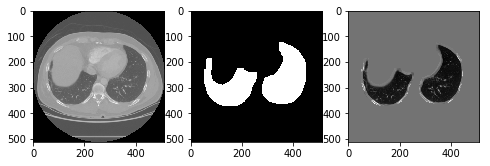

image 1


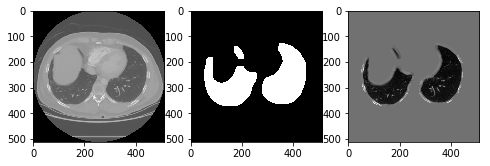

image 2


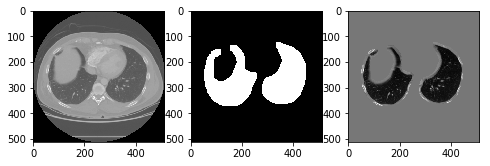

In [22]:
imgs = np.load(output_path+'images_0001_0023.npy')
masks = np.load(output_path+'lungmask_0001_0023.npy')

for i in range(len(imgs)):
    print("image %d" % i)
    fig,ax = plt.subplots(1,3,figsize=[8,8])
    ax[0].imshow(imgs[i],cmap='gray')
    ax[1].imshow(masks[i],cmap='gray')
    ax[2].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show();

In [54]:
lungmask_list = glob(output_path+"lungmask_*.npy")

In [24]:
def apply_ROI(lungmask_list):
    out_images = []      #final set of images
    out_nodemasks = []   #final set of nodemasks

    for filename in tqdm(lungmask_list):
        print ("working on file ", filename)
        imgs_to_process = np.load(filename.replace("lungmask","images"))
        lung_masks = np.load(filename)
        node_masks = np.load(filename.replace("lungmask","masks"))
        for i in range(len(imgs_to_process)):
            mask = lung_masks[i]
            node_mask = node_masks[i]
            img = imgs_to_process[i]
            new_size = [512,512]   # we're scaling back up to the original size of the image
            img= mask*img          # apply lung mask
            #
            # renormalizing the masked image (in the mask region)
            #
            new_mean = np.mean(img[mask>0])  
            new_std = np.std(img[mask>0])
            #
            #  Pulling the background color up to the lower end
            #  of the pixel range for the lungs
            #
            old_min = np.min(img)       # background color
            img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
            img = img-new_mean
            img = img/new_std
            #make image bounding box  (min row, min col, max row, max col)
            labels = measure.label(mask)
            regions = measure.regionprops(labels)
            #
            # Finding the global min and max row over all regions
            #
            min_row, max_row = 512, 0
            min_col, max_col = 512, 0

            for prop in regions:
                B = prop.bbox
                if min_row > B[0]:
                    min_row = B[0]
                if min_col > B[1]:
                    min_col = B[1]
                if max_row < B[2]:
                    max_row = B[2]
                if max_col < B[3]:
                    max_col = B[3]
            width = max_col-min_col
            height = max_row - min_row
            if width > height:
                max_row=min_row+width
            else:
                max_col = min_col+height
            # 
            # cropping the image down to the bounding box for all regions
            # (there's probably an skimage command that can do this in one line)
            # 
            img = img[min_row:max_row,min_col:max_col]
            mask =  mask[min_row:max_row,min_col:max_col]
            if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
                pass
            else:
                # moving range to -1 to 1 to accomodate the resize function
                mean = np.mean(img)
                img = img - mean
                min = np.min(img)
                max = np.max(img)
                img = img/(max-min)
                new_img = resize(img,[512,512])
                new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
                out_images.append(new_img)
                out_nodemasks.append(new_node_mask)
                
    
    return out_images, out_nodemasks

In [25]:
# apply_ROI(lungmask_list)

## save train-test

In [26]:
def final_images_and_masks(out_images, out_nodemasks):    
    num_images = len(out_images)
    #
    #  Writing out images and masks as 1 channel arrays for input into network
    #
    final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
    final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
    for i in tqdm(range(num_images)):
        final_images[i,0] = out_images[i]
        final_masks[i,0] = out_nodemasks[i]

    rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
    test_i = int(0.2*num_images)
    np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
    np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
    np.save(working_path+"testImages.npy",final_images[rand_i[:test_i]])
    np.save(working_path+"testMasks.npy",final_masks[rand_i[:test_i]])

In [27]:
# final_images_and_masks(out_images, out_nodemasks)

## cac

In [28]:
import keras
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

In [29]:
K.set_image_data_format('channels_first')

In [41]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [40]:
def get_unet():
    inputs = Input((1, 512, 512))
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    up_sampling2D = UpSampling2D(size=(2,2))
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Convolution2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [42]:
train_img = np.load(working_path+'trainImages.npy')
test_img = np.load(working_path+'testImages.npy')

train_mask = np.load(working_path+'trainMasks.npy')
test_mask = np.load(working_path+'testMasks.npy')

x_train, y_train, x_test, y_test = train_img, train_mask, test_img, test_mask

In [43]:
model = get_unet()
    # Saving weights to unet.hdf5 at checkpoints
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)

In [45]:
# model.fit(train_img, train_mask, batch_size=2, epochs=20, verbose=1, shuffle=True,
#               callbacks=[model_checkpoint])

In [65]:
model1 = get_unet()
model1.load_weights('C:/Users/tqnha/Downloads/unet (1).hdf5')

In [66]:
num_test = len(test_img)
predicted_test_mask = np.ndarray([num_test,1,512,512],dtype=np.float32)

for i in range(num_test):
    predicted_test_mask[i] = model1.predict([x_test[i:i+1]], verbose=0)[0]
mean = 0.0
for i in range(num_test):
    mean+=dice_coef_np(y_test[i,0], predicted_test_mask[i,0])
mean/=num_test
print("Mean Dice Coeff : ",mean)

Mean Dice Coeff :  1.1872598756396437e-05
